In [1]:
# Import the necessary libraries required.

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Downloading the dataset form tensorflow.

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Normalize the images of the dataset between 0 and 1.

x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
# Flattening the images to 784 dimensional vector.

x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

In [5]:
# Convert the labels of the iamges in train and test data to 0 and 1 based on their remainders upon performing the modulo operation for each label in train and test.

y_train_even_odd = np.array([label % 2 for label in y_train])
y_test_even_odd = np.array([label % 2 for label in y_test])

In [6]:
# Model that has 1 laer of dense neuron, sigmoid actiation function and an input shape of 784.

model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(28 * 28,))])

/Users/parthabhang/Desktop/DL/quantiota/quantiotaenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# All weights and bias initialized with adam optimizer, loss function as binary cross entropy and accuracy is the metrics that is being used. 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Model is fitted over the train data and trained for 5 epochs each with batch size of 32.

history = model.fit(x_train, y_train_even_odd, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step - accuracy: 0.8355 - loss: 0.3805
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - accuracy: 0.8902 - loss: 0.2723
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - accuracy: 0.8943 - loss: 0.2639
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.8978 - loss: 0.2599
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - accuracy: 0.8994 - loss: 0.2579


In [9]:
# Loss is calculated and original accuracy is printed.

loss, accuracy = model.evaluate(x_test, y_test_even_odd)
print(f'Original Test Accuracy: {accuracy:.4f}')

# Empty Array to store the test accuracy after each epoch
test_acc = []

for epoch in range(5):  # 5 epochs as defined
    _, test_accuracy = model.evaluate(x_test, y_test_even_odd, verbose=0)
    test_acc.append(test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.8971 - loss: 0.2673
Original Test Accuracy: 0.9014


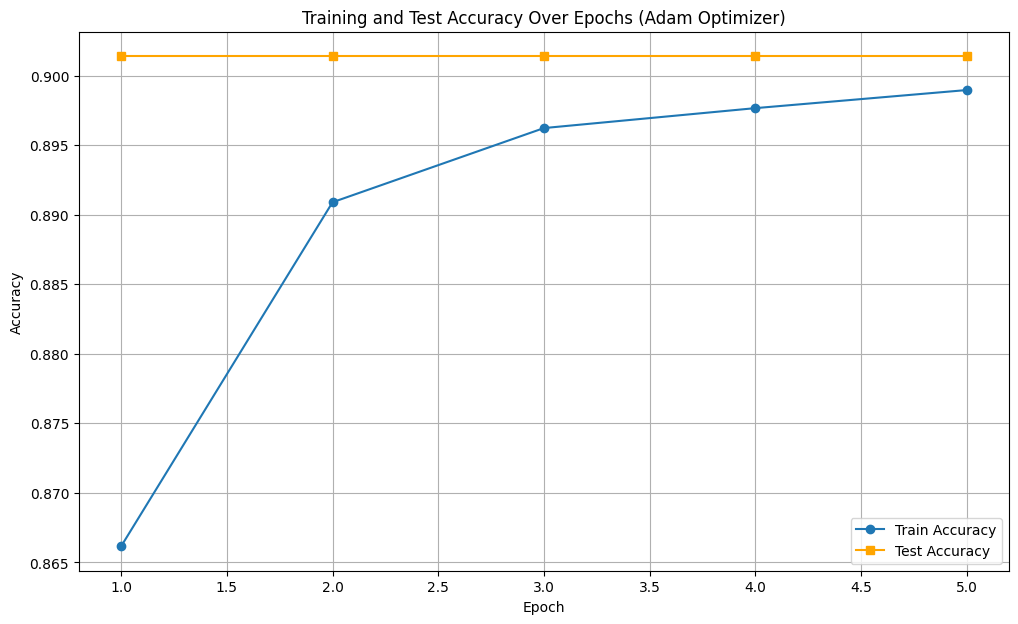

In [10]:
# Get training accuracy from history object.
train_acc = history.history['accuracy']

# Plot training and test accuracy
plt.figure(figsize=(12, 7))
plt.plot(range(1, 6), train_acc, marker='o', label='Train Accuracy')
plt.plot(range(1, 6), test_acc, marker='s', label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs (Adam Optimizer)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Hyperparameters for entropy gradiant based learning.

learning_rate = 0.005  # Step size for updating the weights
delta = 0.1  # contraint for the update in weight. The change in the weight in two consecutive iterations should not be more than this.
epochs = 5  # model is trained over 5 epochs
batch_size = 32  # Each epoch has a batch size of 32. 
input_size = 28 * 28  # Input size of each training iteration is 784.

In [12]:
# Weights for model training

w1 = np.random.randn(input_size) * 0.01  # Primary weight
G1 = np.random.randn(input_size) * 0.01  # Secondary weight
b1 = 0.01  # Bias term added for every step

In [13]:
# Sigmoid activation function applied over every result of the weighted sum of the weight and input

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [14]:
# Function to calculate the magnitude by which the weight should be updated after each epoch using z and d according to the formula

def entropy_gradient(z, D):
    return - (1 / np.log(2)) * z * D * (1 - D)

In [15]:
# Performs the weighted bias and applies the activation function sigmoid over the input x.

def forward_pass(x):
    z = np.dot(x, (w1 + G1)) + b1
    D = sigmoid(z)
    return z, D

In [16]:
accuracy_history = []  # Empty array to store the accuracy for each epoch

# Split train data into small batches for indivisual batch processing during each epoch.
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train_even_odd[i:i + batch_size]

        # Calculates the z and d usig the forward pass function created and also calculates the gradient by which the weight should be updated.
        z, D = forward_pass(x_batch)
        gradient = entropy_gradient(z, D)

        # Weight updation of primary weight, secondary weight and bias using the learning rate and gradient calculated above.
        w1_update = -learning_rate * np.dot(x_batch.T, gradient)
        G1_update = -learning_rate * np.dot(x_batch.T, gradient)
        b1_update = -learning_rate * np.sum(gradient)

        # Constraint enforcement (delta)
        z_change = np.abs(w1_update + G1_update)
        scale_factor = np.minimum(1.0, delta / np.max(z_change))

        # Applying the updated weights and bias above maintaining the constraint that the difference between conscutive weight update should not be more that delta (initialized to 0.1 in hyperparameters)
        w1 += scale_factor * w1_update
        G1 += scale_factor * G1_update
        b1 += scale_factor * b1_update

    # Tests the model based on the weight and bias updates made above into the forward pass function and calculates the accuracy and prints them
    # Calculate training accuracy for the current epoch 
    z_train, D_train = forward_pass(x_train)
    train_predictions = (D_train >= 0.5).astype(int)
    train_accuracy = np.mean(train_predictions == y_train_even_odd)

    # Test accuracy
    z_test, D_test = forward_pass(x_test)
    predictions = (D_test >= 0.5).astype(int)
    test_accuracy = np.mean(predictions == y_test_even_odd)

    # Store test accuracy into the array for plotting
    accuracy_history.append(test_accuracy)

    # Print results per epoch
    print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")



Epoch 1/5, Train Accuracy: 0.5085, Test Accuracy: 0.5074
Epoch 2/5, Train Accuracy: 0.5085, Test Accuracy: 0.5074
Epoch 3/5, Train Accuracy: 0.5085, Test Accuracy: 0.5074
Epoch 4/5, Train Accuracy: 0.5085, Test Accuracy: 0.5074
Epoch 5/5, Train Accuracy: 0.5085, Test Accuracy: 0.5074


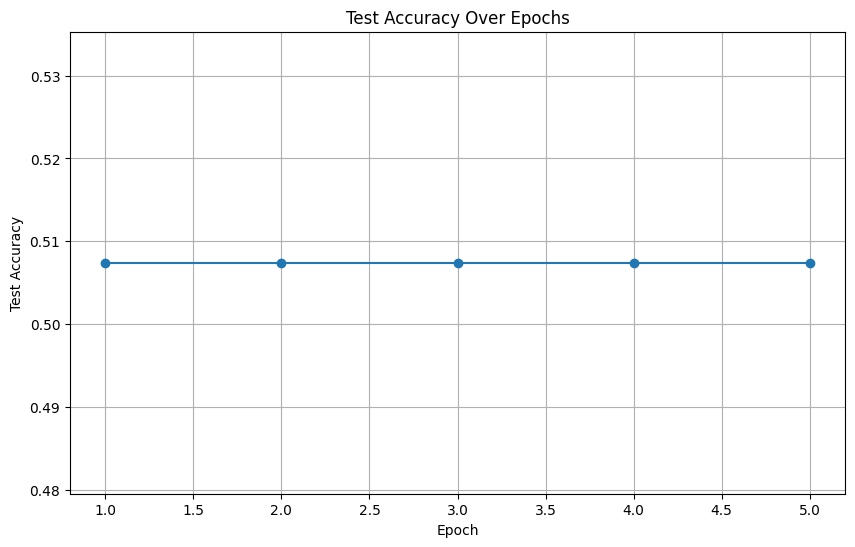

In [17]:
# Plot the accuracy of all the epochs for ntropy gradient based learning

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid()
plt.show()

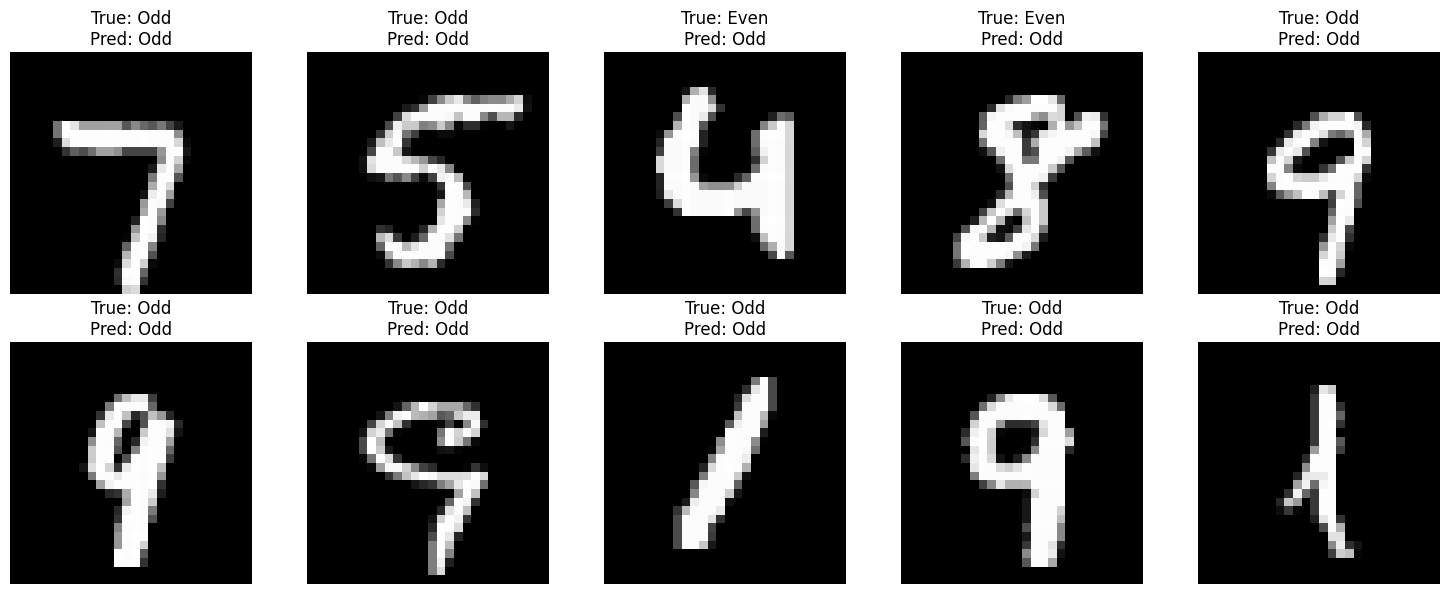


Key Changes Implemented:
1. Dual-weight structure (w1 and G1).
2. Entropy-gradient based direction and magnitude for weight updation.
3. z mapping constraint (|z_i+1 - z_i| < delta).
4. Custom training loop replacing built-in optimizer.


In [18]:
random_indices = np.random.choice(len(x_test), 10, replace=False)  # Predicts some random integers.

# Prints the image, the actual label (0 or 1) and the predicted label (0 or 1) for the random integers calculated above.
plt.figure(figsize=(15, 6))
for idx, i in enumerate(random_indices):
    image = x_test[i].reshape(28, 28)
    true_label = y_test_even_odd[i]
    pred_label = predictions[i]
    true_text = "Odd" if true_label == 1 else "Even"
    pred_text = "Odd" if pred_label == 1 else "Even"

    plt.subplot(2, 5, idx + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"True: {true_text}\nPred: {pred_text}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Key changes made in the code provided.
print("\nKey Changes Implemented:")
print("1. Dual-weight structure (w1 and G1).")
print("2. Entropy-gradient based direction and magnitude for weight updation.")
print("3. z mapping constraint (|z_i+1 - z_i| < delta).")
print("4. Custom training loop replacing built-in optimizer.")